# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [10]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

[[-0.14652784 -0.19562233 -0.41055854 ..., -0.08117054 -0.29217982
  -0.57815755]
 [-0.54573185 -1.12231735 -0.60581502 ..., -0.85403981 -0.64021542  0.        ]
 [-0.82443782 -0.237867   -0.84829588 ..., -0.36203424 -0.30005999
  -0.76637835]
 ..., 
 [-0.29444316 -0.53804889 -1.04375121 ..., -0.74834214 -0.37031691
  -1.48972493]
 [-0.70241987 -0.29496699 -0.34152033 ..., -0.33146985 -0.42109628
  -0.25850171]
 [-0.69150738 -0.61570121 -0.93605438 ..., -0.82443242 -0.33619364
  -1.12165306]]
loss: 2.320051
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [43]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.367126 analytic: -2.367126, relative error: 7.743448e-09
numerical: -4.685901 analytic: -4.685901, relative error: 9.581305e-09
numerical: -0.554564 analytic: -0.554564, relative error: 1.927272e-08
numerical: -0.457222 analytic: -0.457223, relative error: 6.884280e-08
numerical: -3.409814 analytic: -3.409814, relative error: 3.012317e-09
numerical: -0.713420 analytic: -0.713420, relative error: 2.642550e-08
numerical: -3.138610 analytic: -3.138610, relative error: 7.761001e-09
numerical: 1.540203 analytic: 1.540203, relative error: 1.959036e-08
numerical: -2.193499 analytic: -2.193499, relative error: 7.661098e-09
numerical: 1.275900 analytic: 1.275900, relative error: 1.213706e-09
numerical: -0.485084 analytic: -0.485084, relative error: 4.820859e-09
numerical: -0.545663 analytic: -0.545663, relative error: 2.626954e-08
numerical: 3.833038 analytic: 3.833038, relative error: 8.768590e-09
numerical: -2.967911 analytic: -2.967911, relative error: 1.063917e-08
numerical: 0

In [42]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.320051e+00 computed in 0.166160s
vectorized loss: 2.320051e+00 computed in 0.012321s
Loss difference: 0.000000
Gradient difference: 0.000000


In [46]:
from cs231n.classifiers import Softmax
s_max = Softmax()
tic = time.time()
loss_hist = s_max.train(X_train, y_train, learning_rate=1e-7, reg=5e1,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 6.246603
iteration 100 / 1500: loss 4.717121
iteration 200 / 1500: loss 4.320603
iteration 300 / 1500: loss 3.953792
iteration 400 / 1500: loss 3.810336
iteration 500 / 1500: loss 3.572885
iteration 600 / 1500: loss 3.569075
iteration 700 / 1500: loss 3.763640
iteration 800 / 1500: loss 3.377319
iteration 900 / 1500: loss 3.654455
iteration 1000 / 1500: loss 3.558377
iteration 1100 / 1500: loss 3.448213
iteration 1200 / 1500: loss 3.377469
iteration 1300 / 1500: loss 3.470623
iteration 1400 / 1500: loss 3.416178
That took 13.913356s


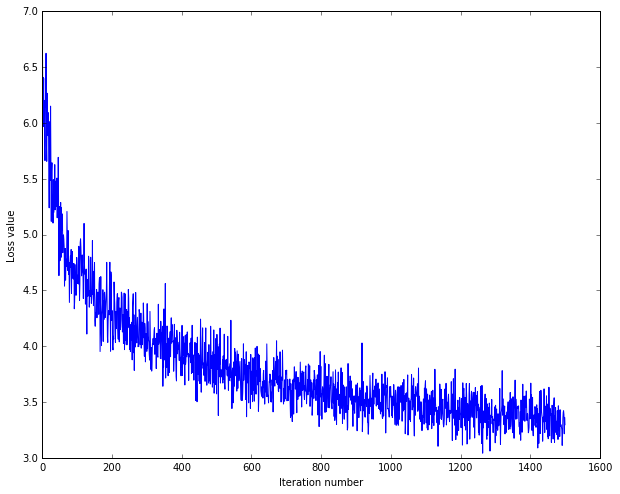

In [47]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [48]:
# Write the Softmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = s_max.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = s_max.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.250755
validation accuracy: 0.247000


In [51]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.logspace(-6, -5, 15) # [1e-7, 5e-7]
regularization_strengths = np.logspace(2, 6, 15) # [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_iterations = 200
for learning_r in learning_rates:
    for regularization_s in regularization_strengths:
        
        # it looks like it is cheaper to construct one every time 
        # then to retrain the best one later
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=learning_r, reg=regularization_s,
                  num_iters=num_iterations, verbose=True)
        
        # compute accuracy for the current train mode
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)

        results[(learning_r, regularization_s)]=(training_accuracy, validation_accuracy)
        
        # store the best valid accuracy and corres
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 200: loss 6.767847
iteration 100 / 200: loss 4.264955
iteration 0 / 200: loss 8.527373
iteration 100 / 200: loss 5.556439
iteration 0 / 200: loss 11.696039
iteration 100 / 200: loss 8.173549
iteration 0 / 200: loss 16.432800
iteration 100 / 200: loss 11.982960
iteration 0 / 200: loss 28.176753
iteration 100 / 200: loss 18.439819
iteration 0 / 200: loss 46.747224
iteration 100 / 200: loss 26.155083
iteration 0 / 200: loss 84.808129
iteration 100 / 200: loss 29.898670
iteration 0 / 200: loss 159.376727
iteration 100 / 200: loss 22.277766
iteration 0 / 200: loss 303.449760
iteration 100 / 200: loss 7.979805
iteration 0 / 200: loss 577.480681
iteration 100 / 200: loss 2.313878
iteration 0 / 200: loss 1108.758018
iteration 100 / 200: loss 2.152509
iteration 0 / 200: loss 2135.921321
iteration 100 / 200: loss 2.175003
iteration 0 / 200: loss 4163.025641
iteration 100 / 200: loss 2.211996
iteration 0 / 200: loss 8011.928740
iteration 100 / 200: loss 2.270897
iteration 0 / 200: l

In [57]:
lr=1.39*10**(-6)

In [58]:
r=10**4

In [60]:
r

10000

In [67]:
# lr 1.389495e-06 reg 1.000000e+04 train accuracy: 0.351122 val accuracy: 0.378000
best_softmax = Softmax()
best_softmax.train(X_train, y_train, learning_rate=1.39e-6, reg=1e4,
                      num_iters=1500, verbose=False)

[158.69885735399419,
 153.9200809389497,
 149.47089782538595,
 145.3452386108782,
 141.15761992443322,
 137.32386219055994,
 133.53996341944929,
 129.09322371412878,
 126.06753640076366,
 122.29493206841407,
 118.75515286397997,
 115.73375789235226,
 112.70115093984839,
 109.37679805434738,
 106.39375909110237,
 103.59662463411507,
 100.73069752007024,
 97.84343975046967,
 95.094092310084491,
 92.5531003373613,
 90.279204644322093,
 87.471936079332224,
 85.238312048622163,
 82.675689767065151,
 80.430297167903603,
 78.227968837221624,
 76.266657073514537,
 74.287891017741956,
 72.078882769477985,
 70.095408649878507,
 68.178059246782524,
 66.34377627413707,
 64.692556934854309,
 62.840048727939546,
 61.282024538499932,
 59.45395918184493,
 58.111246265418771,
 56.299191735719859,
 54.882724069423517,
 53.228130329258562,
 51.910388275453855,
 50.529298620633483,
 49.179580736778831,
 47.906788470910364,
 46.599771255562608,
 45.193345341106863,
 44.10763358846647,
 43.113760557717207,


In [68]:
y_train_pred = best_softmax.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = best_softmax.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.364122
validation accuracy: 0.379000


In [69]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.369000


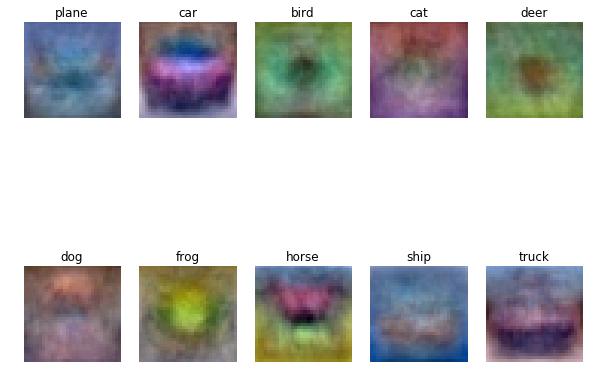

In [70]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])